In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os 
import h5py
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Conv1D, Conv2D, GRU
from tensorflow.keras.layers import TimeDistributed
from tensorflow import keras

In [2]:
plt.rcParams['font.family'] = 'NanumbarunGothic'
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
stock_data = h5py.File("/Users/hwarang/Desktop/Stockprediction_proj/StockData_30years.hdf5", 'r')

In [4]:
_005930 = pd.DataFrame(stock_data['/KOSPI/005930/values'][:], 
                       index = pd.to_datetime(stock_data['/KOSPI/005930/date'][:]),
                       columns = stock_data.attrs['value_names'])

In [5]:
_005930 = _005930['2015-01-01':'2020-06-30']

In [6]:
_005930.head(3)

,Open,High,Low,Close,Volume
2015-01-02,26799,26799,26540,26600,175499
2015-01-05,26720,26720,26260,26660,202790
2015-01-06,26300,26340,25760,25900,304710


### normalize

In [7]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(_005930)

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = ['시가', '고가', '저가', '종가', '거래량']

df_scaled.head()

,시가,고가,저가,종가,거래량
0,0.432242,0.426736,0.430146,0.128105,0.002764
1,0.430968,0.425478,0.425608,0.129566,0.003194
2,0.424194,0.419427,0.417504,0.111057,0.004799
3,0.417419,0.417516,0.415559,0.116902,0.004512
4,0.431935,0.426433,0.424619,0.120312,0.004561


In [8]:
TEST_SIZE = 365
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [9]:
def make_dataset(data, label, window_size=365, predsize = None):
    feature_list = []
    label_list = []

    if isinstance(predsize, int):
        for i in range(len(data) - (window_size + predsize)):
            feature_list.append(np.array(data.iloc[i:i+window_size]))
            label_list.append(np.array(label.iloc[i+window_size:i+window_size+predsize]))
    else:
        for i in range(len(data) - window_size):
            feature_list.append(np.array(data.iloc[i:i+window_size]))
            label_list.append(np.array(label.iloc[i+window_size]))

    return np.array(feature_list), np.array(label_list)

In [10]:
feature_cols = ['종가']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle=False)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
print(test_feature.shape, test_label.shape)

(772, 20, 1) (772, 1)
(193, 20, 1) (193, 1)
(345, 20, 1) (345, 1)


In [11]:
train.shape, test.shape

((985, 5), (365, 5))

In [12]:
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape = [train_feature.shape[1], train_feature.shape[2]]))
model.add(GRU(128))
# model.add(Dense(32, activation='elu'))
model.add(Dense(1))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20, 128)           50304     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 149,505
Trainable params: 149,505
Non-trainable params: 0
_________________________________________________________________


In [14]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [15]:
model_path = './trained_model'
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.001))
early_stop = EarlyStopping(monitor='val_loss', patience=30)
filename = os.path.join(model_path, 'KISTI_proj_GRU.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [16]:
history = model.fit(x_train, y_train, 
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Train on 772 samples, validate on 193 samples
Epoch 1/20
768/772 [============================>.] - ETA: 0s - loss: 0.0666
Epoch 00001: val_loss improved from inf to 0.02171, saving model to ./trained_model\KISTI_proj_GRU.h5
772/772 [==============================] - 4s 6ms/sample - loss: 0.0665 - val_loss: 0.0217
Epoch 2/20
768/772 [============================>.] - ETA: 0s - loss: 0.0087
Epoch 00002: val_loss improved from 0.02171 to 0.01412, saving model to ./trained_model\KISTI_proj_GRU.h5
772/772 [==============================] - 1s 661us/sample - loss: 0.0087 - val_loss: 0.0141
Epoch 3/20
768/772 [============================>.] - ETA: 0s - loss: 0.0083
Epoch 00003: val_loss improved from 0.01412 to 0.00160, saving model to ./trained_model\KISTI_proj_GRU.h5
772/772 [==============================] - 0s 644us/sample - loss: 0.0083 - val_loss: 0.0016
Epoch 4/20
768/772 [============================>.] - ETA: 0s - loss: 0.0031
Epoch 00004: val_loss improved from 0.00160 to 0.00094,

In [17]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

In [18]:
pred.shape

(345, 1)

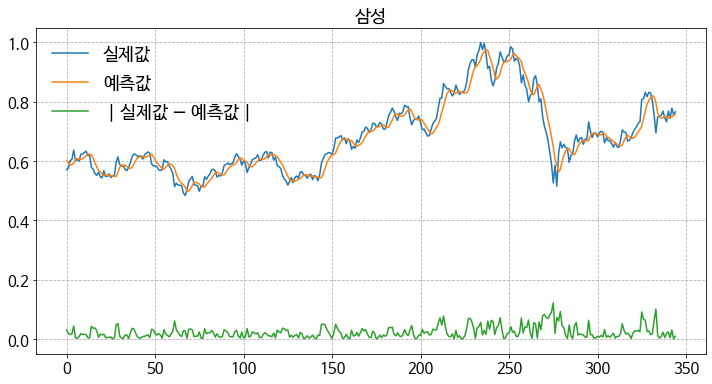

In [19]:
plt.figure(figsize=(12, 6))
plt.rc("font",size=15)
plt.plot(test_label, label='실제값')
plt.plot(pred, label='예측값')
plt.plot(np.sqrt((pred - test_label)**2), label='$\mid$실제값 $-$ 예측값$\mid$')
plt.legend(frameon=False, fontsize = 18)
plt.grid(ls='--')
plt.title("삼성")
plt.show()

In [20]:
test_label.shape

(345, 1)

In [21]:
test_feature.shape, pred.shape

((345, 20, 1), (345, 1))

# MSE

In [22]:
np.mean(keras.losses.mean_squared_error(test_label, pred))

0.0009320758